Загружаем все необходимые библиотеки и читаем данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

train = pd.read_csv("fmnist_train.csv")
test = pd.read_csv("fmnist_test.csv")
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Проверим обучающую выборку на пропуски

In [2]:
# Если хотя бы одна колонка в строке NaN - выводим эту строку
nan_rows = train.isna().any(axis=1)
train[nan_rows]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
17039,5,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17039


Видим, что пропущенные значения есть всего у одной записи. Это менее 0,01% от всей выборки, поэтому можему удалить эту строку

In [3]:
train = train[~nan_rows]

Так же проверим пропуски в данных, на которых нужно будет строить предсказание

In [4]:
# Проверим тестовый датасет на пропущенные значения
nan_rows = test.isna().any(axis=1)
test[nan_rows]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id


Преобразуем данные к нужному для обучения модели формату. Разбиваем на тренировочную и валидационную выборку

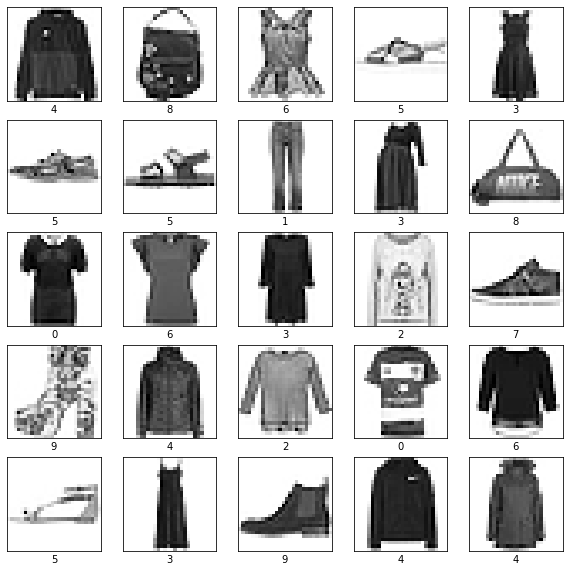

In [5]:
# Задаём целевую переменную
y = train["label"].values

# Преобразовываем пиксели в плоские массивы
X = train.drop(columns=['label', 'Id']).values

# Центрируем и нормируем
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Разбиваем данные из fmnist_train.csv на train / test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Посмотрим примеры
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

Заранее преобразуем данные из соревновательной выборки к формату выше

In [6]:
test_ids = test["Id"]
test_values = test.drop(columns=["Id"]).values
test_values = test_values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [7]:
# Собираем архитектуру модели
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # минимизируем кросс-энтропию
    metrics=['accuracy']  # выводим процент правильных ответов
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [8]:
# Обучаем модель
history = model.fit(
            X_train, 
            y_train,
            batch_size=64,
            epochs=15,
            validation_data=(X_val, y_val)
        )

# Получаем метрики loss и accuracy на валидационной выборке
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"Loss: {round(val_loss, 3)}")
print(f"Accuracy: {round(val_acc, 3)}")

Epoch 1/15
213/213 [==============================] - 6s 24ms/step - loss: 0.9201 - accuracy: 0.6691 - val_loss: 0.5336 - val_accuracy: 0.8093
Epoch 2/15
213/213 [==============================] - 5s 23ms/step - loss: 0.5708 - accuracy: 0.7875 - val_loss: 0.4570 - val_accuracy: 0.8436
Epoch 3/15
213/213 [==============================] - 5s 23ms/step - loss: 0.5016 - accuracy: 0.8131 - val_loss: 0.4281 - val_accuracy: 0.8468
Epoch 4/15
213/213 [==============================] - 5s 23ms/step - loss: 0.4534 - accuracy: 0.8331 - val_loss: 0.4072 - val_accuracy: 0.8574
Epoch 5/15
213/213 [==============================] - 5s 23ms/step - loss: 0.4223 - accuracy: 0.8467 - val_loss: 0.3960 - val_accuracy: 0.8589
Epoch 6/15
213/213 [==============================] - 5s 23ms/step - loss: 0.3909 - accuracy: 0.8529 - val_loss: 0.3693 - val_accuracy: 0.8706
Epoch 7/15
213/213 [==============================] - 5s 23ms/step - loss: 0.3730 - accuracy: 0.8645 - val_loss: 0.3690 - val_accuracy: 0.8665

Сохраняем результат

In [9]:
# Предсказываем вероятность
probs = model.predict(test_values)

# Определяем к какому классу относится запись
pred_labels = np.argmax(probs, axis=1)

submission = pd.DataFrame({
    'Id': test_ids,
    'label': pred_labels
})

submission.to_csv('fmnist_submission.csv', index=False)
submission

,Id,label
0,0,0
1,1,1
2,2,2
3,3,6
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8
